In [ ]:
#requirements
!pip install beautifulsoup4
!pip install requests
!pip install pandas
!pip install numpy

In [ ]:
#imports
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt


In [ ]:
# functions

def extract_recipe_page(soup,title):
  details = {}

  #Title
  details["Title"] = title

  #Image
  image_element = soup.find("div", class_="wprm-recipe-image wprm-block-image-normal")
  details["Image"] = extract_img(image_element)

  #Calories
  calories_element = soup.find("span",class_="wprm-recipe-calories")
  details["Calories"] = extract_cal(calories_element)

  #Personal Points
  pp_element = soup.find("span", class_="wprm-recipe-rating-average")
  details["Points"] = extract_pp(pp_element)

  #Summary
  summary_element= soup.find("div", class_="wprm-recipe-summary wprm-block-text-normal")
  details["Summary"] = extract_summary(summary_element)

  #Recipe Keys
  key_elements = soup.find("ul", class_="cat-icons post-icons")
  details["Keys"] = extract_keys(key_elements)

  return details

def extract_img(image_element):
  if image_element:
     img_url =image_element.find('img', class_='attachment-square size-square').get('data-lazy-src')
  else:
     img_url ="https://t4.ftcdn.net/jpg/04/70/29/97/360_F_470299797_UD0eoVMMSUbHCcNJCdv2t8B2g1GVqYgs.jpg"
  return f'<img src="{img_url}" width="100">'
def extract_cal(calories_element):
  if calories_element:
    return calories_element.text.strip()
  else:
    return np.nan

def extract_pp(pp_element):
  if pp_element:
    return pp_element.text.strip()
  else:
    return np.nan

def extract_summary(summary_element):
  if summary_element:
    return summary_element.text.strip()
  else:
    return "No summary"

def extract_keys(key_elements):
  sub_keys= []

  if key_elements:
    for element in key_elements:
      sub_keys.append(element.text.strip())

    if not sub_keys:
          return np.nan


    return sub_keys

  else:
    return np.nan

In [ ]:
root = "https://www.skinnytaste.com/recipe-index/?_paged="
def main(page_amount):
  titles = []
  images= []
  calories= []
  points= []
  summary =[]
  keys =[]
  for page_number in range(1,page_amount +1):

    page = requests.get(root + str(page_number))
    if page.status_code == 200:
      soup = bs(page.text ,"html.parser")

      search_results = soup.find("main",id="main").find("div", class_="ast-row")
      for article in search_results.find_all("article"):
        title = article.find('h2', class_='entry-title').get_text(strip=True)
        article_page = requests.get(article.find('h2', class_='entry-title').find('a')['href'])
        if article_page.status_code ==200:
          article_soup = bs(article_page.text ,"html.parser")
        #check that it is not a cookbook
        if "wprm-recipe-header-inner" in  article_page.text:

          recipe_details = extract_recipe_page(article_soup,title)
          if recipe_details:
                    titles.append(recipe_details['Title'])
                    images.append(recipe_details['Image'])
                    calories.append(recipe_details['Calories'])
                    points.append(recipe_details['Points'])
                    summary.append(recipe_details['Summary'])
                    keys.append(recipe_details['Keys'])

        else:
          print("skipped article: " + title)

  data = {
          'Title': titles,
          'Image': images,
          'Calories': calories,
          'Points': points,
          'Summary': summary,
          'Keys': keys
      }
  df = pd.DataFrame(data)
  return df

In [ ]:
# Step1 – Webscraping
# Step 2 – Filter interesting data
df = main(50)
display(HTML(df.to_html(escape=False)))

skipped article: Free 7 Day Healthy Meal Plan (Sept 23-29)
skipped article: 16+ Easy Sheet Pan Dinners
skipped article: 36+ Best Air Fryer Chicken Recipes
skipped article: 20+ Amazon Prime Day Deals I Love on Air Fryers, My Cookbooks, and More
skipped article: 15 Perfect Pasta Salad Recipes
skipped article: 20 Must-Have Kitchen Tools for Healthy Eating
skipped article: 30 Awesome Last Minute Father’s Day Gifts You Can Still Get
skipped article: 21 Summer Dinner Ideas
skipped article: My Favorite Memorial Day Sales You Can Still Get
skipped article: 25 Summer Side Dishes
skipped article: 35 Perfect Last-Minute Mother’s Day Gifts That She Will Love
skipped article: 18 Easy Taco Recipes
skipped article: 15 Easy Chickpea Recipes
skipped article: The Best Amazon Big Spring Sale Deals Still Available
skipped article: The 5 Best Blenders for Smoothies of 2024
skipped article: The 4 Best Wood Cutting Boards of 2024
skipped article: The Best Presidents Day Sales on Air Fryers, Pantry Storage, a

,Title,Image,Calories,Points,Summary,Keys
0,Red Curry Salmon,,349,NaN,"Thai-inspired Red Curry Salmon is simmered in an incredibly tasty coconut red curry sauce with bell peppers, garlic and onions.","[DF, GF, HP]"
1,Apple Butter,,34,NaN,"This easy apple butter recipe simmers on the stove, made with apples, cinnamon, nutmeg, and allspice, it smells and tastes like fall!","[DF, GF, KF, V]"
2,Roasted Delicata Squash,,177,5,"Roasted Delicata Squash with toasted almonds, sweetened with maple syrup and seasoned with sage and paprika, makes a perfect fall side dish.","[DF, GF, V]"
3,Apple Bread,,124,4.83,"Moist cinnamon apple bread recipe made with applesauce, small chunks of fresh apples and walnuts in every bite. It's so moist and delicious, you won't believe it's light!",[V]
4,Autumn Salad with Pears and Gorgonzola,,175,5,"I love a good fall salad with lots of texture and flavors, and this Autumn Salad with sweet pears, crunchy pecans, and Gorgonzola nails it!","[GF, LC, Q, V]"
5,Sesame Chicken,,513,4.64,"This healthy Sesame Chicken recipe features chicken breast bites in a sweet, savory, tangy, and slightly spicy sauce topped with sesame seeds and green onions.","[DF, FM, GF, HP]"
6,Bacon in the Oven,,60,5,"Whether you're a fan of tender, crisp, or extra crispy bacon, this simple method of cooking bacon in the oven is easy. There’s no stove top mess, and it frees up your stove for cooking other breakfast items!","[DF, GF, HP, KF, LC, Q, W]"
7,Pumpkin Spice Latte,,115,5,Embrace the cozy fall vibes with this homemade Pumpkin Spice Latte recipe! You can make your own at home for a fraction of the cost.,"[DF, GF, V]"
8,Homemade Hamburger Helper,,453,4.91,"This one-skillet, creamy Homemade Hamburger Helper is made with ground beef, macaroni and cheese – real ingredients you can feel good about feeding your family for dinner!","[DF, GF, HP, KF, Q]"
9,Fried Brown Rice,,276,4.50,Brown fried rice is a healthy twist on classic fried rice with some extra hidden veggies to bulk it up. Just add your favorite protein to make it a meal!,"[DF, GF, HF, Q, V]"


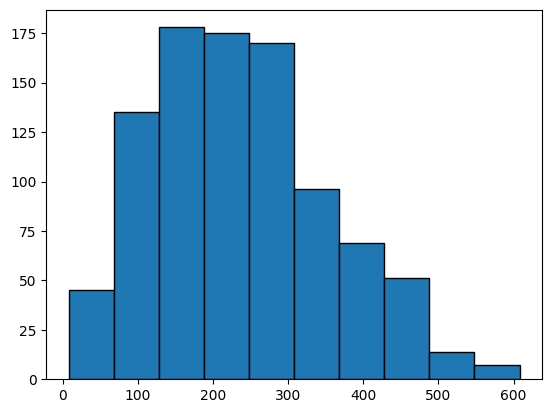

Keys
GF    699
KF    513
Q     460
DF    442
V     405
LC    271
HF    244
HP    210
MP    150
FM    143
W     121
AF    102
PC     34
SC     28
Name: count, dtype: int64


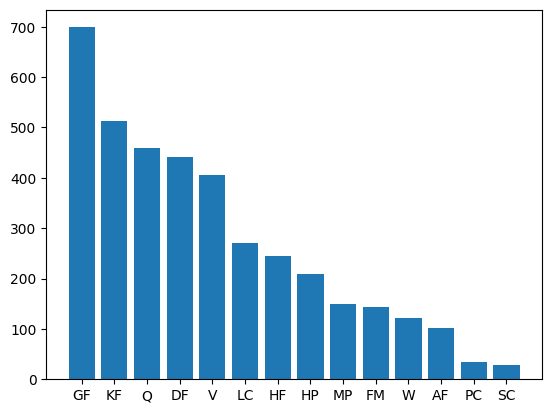

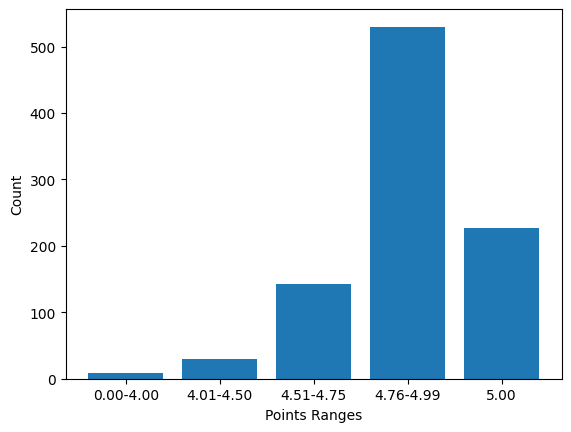

In [ ]:
# Step 3 – EDA and Visualisation
df["Calories"] = pd.to_numeric(df["Calories"], errors="coerce")
df["Points"] = pd.to_numeric(df["Points"], errors="coerce")


# Calories distribution (Historgram)
df_calories= df["Calories"].dropna().reset_index(drop=True)
plt.hist(df_calories, edgecolor="black")
plt.show()
# Recipe key distribution (Bar plot)
df_keys = df["Keys"].explode("Keys")
key_counts = df_keys.value_counts()
plt.bar(key_counts.index, key_counts.values)
print(key_counts)
plt.show()
# Points distribution (Histogram)
bins = [0, 4, 4.5, 4.75, 4.99, 5]
labels = ["0.00-4.00", "4.01-4.50", "4.51-4.75", "4.76-4.99", "5.00"]
df_points= pd.cut(df["Points"].dropna(), bins=bins, labels=labels, right=True)
points_counts = df_points.value_counts().sort_index()

plt.bar(points_counts.index, points_counts.values)
plt.xlabel("Points Ranges")
plt.ylabel("Count")

plt.show()

In [ ]:
# Step 4 – User interaction

# Input a calorie range
cal_low = float(input("Enter calories lower limit: "))
cal_high = float(input("Enter calories high limit: "))

# Input a point range
points_low = float(input("Enter points lower limit: (0-5) "))
points_high = float(input("Enter points high limit: (0-5)"))
filtered_df = df[(df["Calories"] >= cal_low) & (df["Calories"] <= cal_high) & (df["Points"] >= points_low) & (df["Points"] <= points_high) ]


# Output the first 10 foods sorted based on calories, include their image and their summary.
filtered_df = filtered_df.sort_values(by="Calories", ascending=True)
filtered_df = filtered_df.drop(columns=["Title","Calories","Points","Keys"])
filtered_df = filtered_df.head(10)
display(HTML(filtered_df.to_html(escape=False)))


Enter calories lower limit: 0
Enter calories high limit: 1234
Enter points lower limit: (0-5) 0
Enter points high limit: (0-5)5


,Image,Summary
240,,"Next time you're planning to make tacos, skip the store-bought packets and whip up your own homemade taco seasoning. It's the best taco seasoning recipe, I've been using this for years!"
32,,"This sugar-free, virgin Mojito mocktail is refreshing when you want an adult cocktail, without the alcohol. Filled with lime, fresh mint and lemon-lime seltzer, they're perfectly enjoyable to drink."
875,,"Air Fried Shishito Peppers come out charred and blistered with the air fryer, which uses much less oil! A squeeze of lemon juice and they are delicious!"
247,,"This easy pickled red onion recipe is delicious and versatile. The pickled onions add a tangy, slightly sweet, and crunchy element to steaks, sandwiches, tacos, burrito bowls and more!"
153,,"Made with just a handful of ingredients in one pot, this rich and flavorful Turkey Stock recipe is the secret to creating a memorable turkey gravy. You'll never buy stock at the store again!"
717,,"This super-simple-to-prepare Citrus Immunity Shot is made with immune-boosting citrus, turmeric, and garlic, a delicious way to start your day!"
80,,"This quick and easy recipe for oven-roasted asparagus is the perfect spring side dish. This basic recipe can be seasoned many different ways—add lemon juice, garlic, or shaved parmesan for variations."
449,,"Puerto Rican Sofrito is the base for so many dishes, like stews, roast pork, bistec, and beans, made with fresh cilantro, garlic, onions, bell peppers, and other ingredients."
152,,This homemade Turkey Gravy from stock is my mom’s tried and true recipe. It’s a staple on our Thanksgiving table every year.
682,,"Craving a Bloody Mary but doing a dry challenge? Make this Virgin Bloody Mary, also known as the Virgin Mary, and you won’t miss the vodka!"
